# Проект выполнил: *Светлаков Сергей, студент SkillFactory группы DSPR-38 (DSPR-1)*
# Проект: *Ford VS Ferrari*
# Дата начала работы: *04.05.2021*
# Дата сдачи: *06.05.2021*

## Цель работы: создать и обучить нейронную сеть по типу CNN (сверточная нейронная сеть) для решения задачи классификации изображений по классам. В качестве изображений выступают фото машин, а классов - модели автомобилей. Метрика: точность предсказаний. Данная работа выполнялась на основе имеющегося Base-Line решения на платформе SkillFactory.

***
***В данном notebook представлена финальная версия программы с промежуточными пояснениями к прошлым версиям.***
***

***
***Для ускорения расчетов используется видео-карта, представленная площадкой Kaggle.***
***

In [ ]:
#Информация по видео-карте
!nvidia-smi

Thu May  6 09:33:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Подключение библиотек

In [ ]:
#Подключение библиотек
#Для работы с данными
import numpy as np
import pandas as pd
#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
#Для работы с файлами
import pickle
import zipfile
import csv
import sys
import os
#Для работы с изображениями
import PIL
from PIL import ImageOps, ImageFilter
#Для разбиение выборок
from sklearn.model_selection import train_test_split, StratifiedKFold
#Для работы с ML-CV
import tensorflow as tf
import tensorflow.keras.layers as L                                    #Типы слоев
import tensorflow.keras.models as M                                    #Типы моделей
import tensorflow.keras.optimizers as O                                #Типы решателей
from tensorflow.keras.regularizers import l2                           #Регуляризация для Dense
from tensorflow.keras.preprocessing import image                       
from tensorflow.keras.preprocessing.image import ImageDataGenerator    #Генератор (для test)
from tensorflow.keras.callbacks import Callback,\
                                       EarlyStopping,\
                                       LearningRateScheduler,\
                                       ReduceLROnPlateau,\
                                       ModelCheckpoint

***
***Далее устанавливаются и подключаются еще несколько библиотек для fine-tuning и augmentation.***
***

In [ ]:
#Изменение размера и оформления графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [ ]:
print('Версии используемых библиотек:')
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Версии используемых библиотек:
Python       : 3.7.10 (default, Feb 20 2021, 21:17:23) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [ ]:
#Подключение файлов с google-диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Настройки для CV-моделей

***
***Заранее вынесем настройки нейронной сети, перед ее созданием и обучением.***
***Несколько слов о том, как выбирались настройки: сначала были взяты параметры с Base-Line решения SkillFactory, затем при обучении и дообучении модели параметры выбирались так, чтобы получить максимальную точность accuracy, при условии предотвращения возникновения ошибки OOM: out of memory - дефицит машинной памяти на используемом вычислительном ресурсе - видеокарте. Исходный BATCH_SIZE (размер батча) был равен 64 и для fine-tuning выбрана модель EfficientNetB6, но уже при разморозке сети на 50% появлялась ошибка OOM. В итоге была выбрана новая модель для transfer learning - EfficientNetB5, а размер батча снижен до 32, чтобы предотвратить OOM. Количество эпох изначально было равно 5, но было повышено до 15. После предварительных расчетов было выявлено, что количество эпох можно снизить до 8-10, так как дальнейшее обучение модели приводит к снижению метрики качества на валидационной выборке.***
***

In [ ]:
#Параметры сети
RANDOM_SEED    = 42   #Воспроизведение результатов
EPOCHS         = 10   #Количество эпох на обучение
BATCH_SIZE     = 16   #BATCH, подаваемый в сеть
LR             = 1e-3 #Скорость обучения
VAL_SPLIT      = 0.15 #Размер валидационной выборки в сравнении с общей
#Параметры изображения
CLASS_NUM      = 10   #Количество классов в задачей
IMG_SIZE       = 224  #Размер изображения, подаваемого в сеть
IMG_CHANNELS   = 3    #Количество каналов: красный, зеленый, синий
input_shape    = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
#Пути хранения файлов
DATA_PATH = 'drive/MyDrive/SF/Проект_7/sf-dl-car-classification/'  #Директория, содержащая данные
PATH = "car/"                                             #Директория, содержащая модели

# 3. EDA

***
***Чтобы не перегружать хранилище на Kaggle (max 20GB) каждый раз перед повторным запуском очищаем директорию working.***
***

In [ ]:
#Чтение обучающей выборки
df_train = pd.read_csv(DATA_PATH+"train.csv")
#Чтение для submit на Kaggle
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
#Осмотр данных
df_train.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


***
***Видно, что DataFrame состоит из ссылки на картинку и какому классу принадлежит данная прецендент (картинка).***
***

In [ ]:
#Информация о DF
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


***
***В DataFrame нет пропущенных или лишних значений.***
***

In [ ]:
#Распределение прецендентов по классам
df_train['Category'].value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

***
***Присутствует небольшой дисбаланс классов, но на первоначальном этапе попробуем не применять OverSampler или UnderSampler.***
***

In [ ]:
#Распаковка картинок - извлечение в PATH
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
#Название извлеченных папок 
print('Название извлеченных папок: {}'.format(os.listdir(PATH)))

Название извлеченных папок: ['test_upload', 'train']


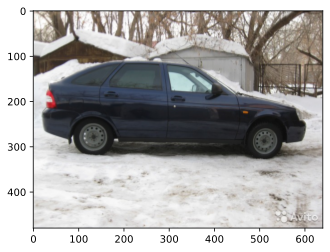

In [ ]:
#Извлечение случайной картинки
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
#построение графика
imgplot = plt.imshow(image)
#Отображение
plt.show()

***
***Каждый прецендент содержит фото автомобиля. Посмотрим на еще несколько картинок, чтобы понять: все ли автомобили сфотографированы с одного ракурса?***
***

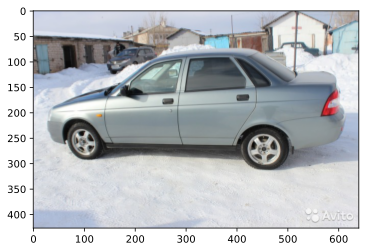

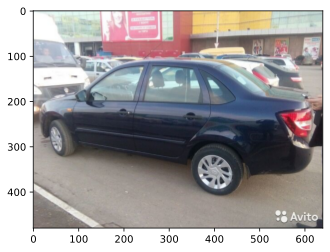

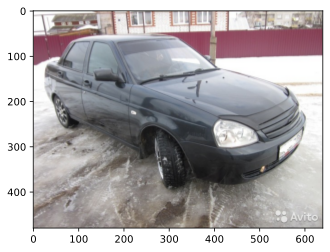

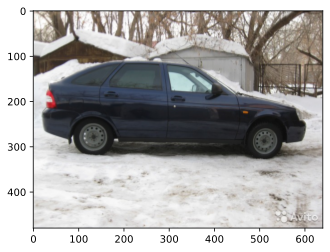

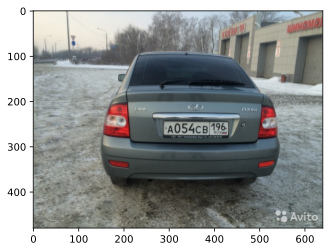

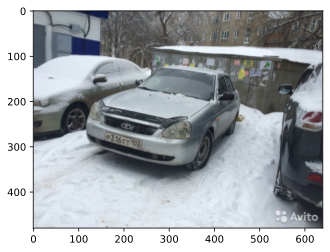

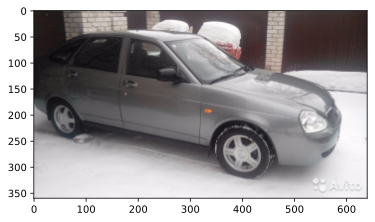

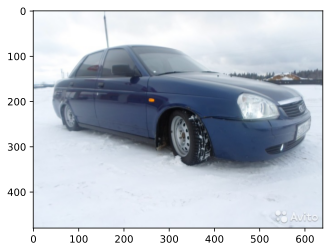

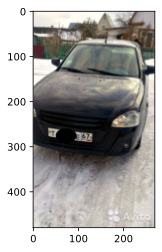

In [ ]:
#Перебор
for name in df_train['Id'].iloc[:9].values:
    #Извлечение случайной картинки
    image = PIL.Image.open(PATH+'/train/0/'+name)
    #построение графика
    imgplot = plt.imshow(image)
    #Отображение
    plt.show()

***
***Ракурс может быть абсолютно случайным. Может быть случайным и размер фотографии. Также где-то присутствует случайным шум, разная контрасность, цветовая гамма и так далее. Если не учесть все эти факторы - это может привести к обучению некачественной модели. Для улучшения качества предсказаний применим аугментацию данных - сгенерируем на основе имеющихся изображений случайные новые, созданные на основе исходных, путем добавления различных эффектов, разворота/поворота/сдвига и так далее. Стоит упомянуть, что изображение цветное, значит каналов будет 3: red, green, blue.***
***

# 4. Аугментация данных

***
***Для аугментации данных используем библиотеку albumentations. А обертку для TensorFlow скачаем по ссылке от SkillFactore.***
***

In [ ]:
#Используем готовую "продвинутую" библиотеку для аугментации данных
#Ссылка SkillFactory
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-4e0tpbi4
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-4e0tpbi4
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp37-none-any.whl size=29530 sha256=e12e7966562518da4435a14fc0ca3015ad082e53fa489ce9225b60ed0f4980e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqdxzh4j/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor


In [ ]:
#Для Google Colab
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-3djg3e17
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-3djg3e17
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=93094 sha256=7cf8970602cfe193f29a535825408d45552dd407f6b587b668d7cafd1341ff32
  Stored in directory: /tmp/pip-ephem-wheel-cache-baix5ow0/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
#Импорт библиотек для аугментации
import albumentations as alb
from ImageDataAugmentor.image_data_augmentor import *

***
***По ссылке ниже изучим какие можно добавить эффекты на изображения и поэкспериментируем, как добавление/удаление их сказывается на качестве модели при ее обучении.***
***

In [ ]:
#Ссылка - https://albumentations.ai/docs/api_reference/augmentations/transforms/
#         #albumentations.augmentations.transforms.GaussianBlur
p = 0.5 #Вероятность изменить изображение
#Создание аугментатора
augment = alb.Compose([
    #Замена каналов в RGB палитре
    alb.ChannelShuffle(p=p),
    #   #Увеличение изображение RGB по статье Крижевского
    #   alb.FancyPCA(p=p),
    #Размытие изображения
    alb.GaussianBlur(p=p),
    #Добавление шума
    alb.GaussNoise(p=p),
    #   #Добавление шума
    #   alb.GlassBlur(p=p),
    #Поворот вокруг вертикальной оси
    alb.HorizontalFlip(p=p),
    #Изменение оттенка и насыщенности
    alb.HueSaturationValue(p=p),
    #   #Размытие в движение
    #   alb.MotionBlur(p=p),
    #Изменение яркости
    alb.RandomBrightness(p=p,limit=(0.2,0.4)),
    #Изменение контраста
    alb.RandomContrast(p=p,limit=(0.1,0.3)),
    #   #Имитирование вспышки
    #   alb.RandomSunFlare(p=p),
    #Сдвиг в RGB палитре
    alb.RGBShift(p=p),
    #Вращение изображения
    alb.ShiftScaleRotate(shift_limit=0.0625,      #Коэффициент изменения сдвига
                         scale_limit=(0.1,0.2),   #Коэффициент изменение масштаба
                         interpolation=1,         #Флаг для вида интерполяции (линейная)
                         border_mode=4,           #Флаг для экстраполяцц (отражение)
                         rotate_limit=20,         #Угол поворота
                         p=0.7),                  #Вероятность
    #Изменение размера на заданный
    alb.Resize(IMG_SIZE, IMG_SIZE)
])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


***
***Опытным путем было установлено, что попытка смоделировать солнечную вспышку или размытость фотографии из-за движения фотографирующего не привела ни к чему хорошему.***
***

In [ ]:
#Генератор для обучающей и валидационной выборок
train_gen = ImageDataAugmentor(rescale=1.0/255,                     #Масштабирование
                               augment=augment,                     #Аугментатор
                               seed=RANDOM_SEED,                    #Для воспроизведения
                               validation_split=VAL_SPLIT)          #Размер выборки
#Генератор для тестовой выборки
test_gen = ImageDataGenerator(rescale=1.0/255)
#Создание обучающей выборки
train_datagen = train_gen.\
            flow_from_directory(PATH+'train/',                      #Путь
                                class_mode='categorical',           #Тип данных
                                batch_size=BATCH_SIZE,              #Размер BATCH'а
                                target_size=(IMG_SIZE, IMG_SIZE),   #Размер матрицы
                                shuffle=True,                       #Перемешиваем заранее
                                subset='training')                  #Название
#Создание валидационной выборки
test_datagen = train_gen.\
            flow_from_directory(PATH+'train/',                      #Путь
                                class_mode='categorical',           #Тип данных
                                batch_size=BATCH_SIZE,              #Размер BATCH'а
                                target_size=(IMG_SIZE, IMG_SIZE),   #Размер матрицы
                                shuffle=True,                       #Перемешиваем заранее
                                subset='validation')                #Название
#Создание тестовой выборки
test_sub_generator = test_gen.\
            flow_from_dataframe(dataframe=sample_submission,
                                x_col="Id",
                                y_col=None,
                                directory=PATH+'test_upload/',
                                class_mode=None,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                target_size=(IMG_SIZE, IMG_SIZE),
                                seed=RANDOM_SEED)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


***
***Создали 2 генератора и на их основе сгенерировали 3 группы изображений: обучающая и валидационная выборки (train_gen) и тестовая выборка (test_gen).***
***

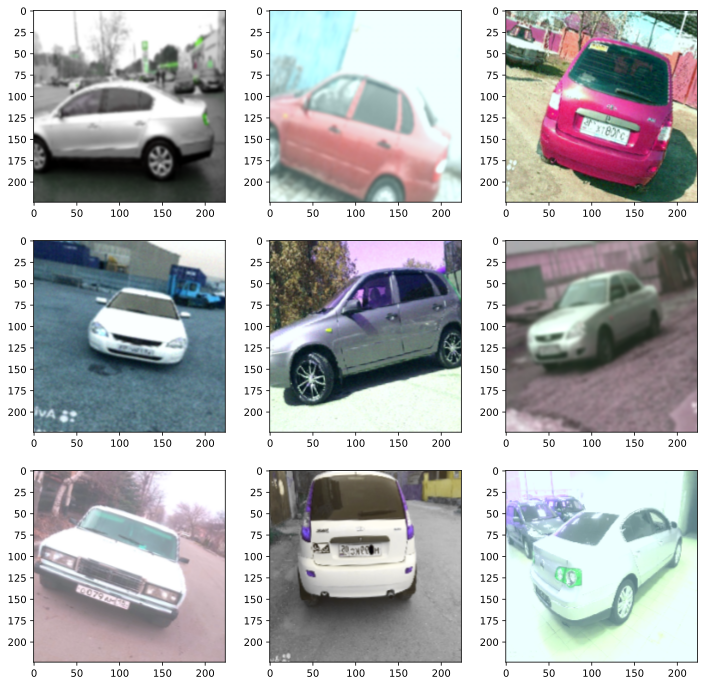

In [ ]:
#Импорт библиотеки для просмотра изображений
from skimage import io

#Функция для просмотра изображений
def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()
    pass

#Создание массива
x,y = train_datagen.next()
#Размер картинки
plt.figure(figsize=(12,12))
#Перебор
for i in range(0,9):
    #Извлечении картинки
    image = x[i]
    #Создание места для графика
    plt.subplot(3,3, i+1)
    #Добавление картинки
    plt.imshow(image)
#Вывод
plt.show()

***
***Видно, что аугментация прошла успешна. Видны примеры измения контрасности, освещения и т.д.***
***

# 5. Извлечение 'головы' и создание модели - SOTA

***
***Для улучшения качества предсказаний в достаточно ограниченном количестве ресурсов, как временных, так и вычислительных, воспользуемся готовой обученной моделью и постепенно переобучим готовую модель под данную задачу. Данная операция называется fine-tuning, если обучение частичное и transfer learning, если переобучается вся 'голова'.***
***

In [ ]:
#https://paperswithcode.com/sota/image-classification-on-imagenet
#Установка библиотеки
!pip install -q efficientnet

     |████████████████████████████████| 51kB 8.2MB/s 


In [ ]:
#Импорт библиотек для аугментации
import efficientnet.tfkeras as efn

***
***Изначально в качестве 'головы' модели выбрана модель EfficientNetB6, но из-за большого количества весов в ней (60 млн.) сеть не поддается обучению из-за ограничения по количеству используемой памяти. Поэтому модель была заменена на EfficientNetB5. Также тестировалась модель Xception, но она показывала результат на 1-2% хуже.***
***

In [ ]:
#Базовая модель
base_model = efn.EfficientNetB5(weights='imagenet',        #Обученная на imagenet
                                include_top=False,         #Включать ли верхнюю часть сети
                                input_shape=input_shape)   #Размер матрицы

115515392/115515256 [==============================] - 1s 0us/step


***
***Далее необходимо сконструировать архитектуру сети. Ниже представлена финальная версия, которая дала наилучший результат. Также в качестве комментариев под кодом приведены различные ранние версии и причины, по которым они не используются.***
***

In [ ]:
#Создание модели для обучения
model = M.Sequential()
#Добавление слоев
model.add(base_model)                                #Слой 1 - базовая модель B6
model.add(L.GlobalAveragePooling2D())                #Слой 2 - пулинг слой
model.add(L.Dense(256,                               #Слой 3 - обычная сеть
                  activation='relu',
                  bias_regularizer=l2(1e-4),
                  activity_regularizer=l2(1e-5)))
model.add(L.BatchNormalization())                    #Слой 4 - Batch-нормализация
model.add(L.Dropout(0.25))                           #Слой 5 - Drop нейронов
model.add(L.Dense(CLASS_NUM,                         #Слой 6 - Выходной слой
                  activation='softmax'))

***
***В финальной версии для ускорения сходимости применяется Батч-нормализация. Также для предотвращения переобучения применяется регуляризация к Dense слою. Дополнительно для предотвращения переобучения применяется DropOut слой.***
***

In [ ]:
#Вариант 1: Dense cлой 256 + relu (итоговый)
#Вариант 2: Dense cлой 512 + relu
#Вариант 3: Dense cлой 256 + elu
#Вариант 4: Dense cлой 256x256 + relu

***
***Вариант 2 практически не дал никакой разницы, лишь увеличил время обучения. Вариант 3 улучшил качество на валидационной выборке, но ухудшил на Kaggle (скорее всего переобучение). Вариант 4 не также, как и вариант 3 улучшил качество, но совсем незначительно. Для вариант 4 после дополнительного Dense слоя применяется батч-нормализация и drop-out слой.***
***

# 6. Обучение модели (transfer-learning+finetuning)

***
***Для улучшения качества обучения добавим функции, которые помогают фиксировать лучший результат и изменять темп обучения в автоматическом режиме. Была попытка использовать LearningRateScheduler, но она не привела к значимым результатам.***
***

In [ ]:
#Сохранение прогресса обучения
#Сохранение модели
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'],    #Метрика контроля
                             verbose = 1,                   #Вывод информации
                             mode = 'max')                  #Max metrics
#Ранняя оставка, когда метрика не растет
earlystop = EarlyStopping(monitor = 'val_accuracy',         #Метрика контроля
                          patience = 5,                     #Кол-во эпох без роста
                          restore_best_weights = True)      #Если провал, то возврат?
#Уменьшение темпа обучения, когда метрика падает
reduce_lr = ReduceLROnPlateau(monitor='val_loss',           #Метрика контроля
                              factor=0.2,                   #Во сколько раз снижается
                              patience=3,                   #Кол-во эпох без улучшения
                              min_lr=0.000001,              #Минимальное значение
                              verbose=1,                    #Вывод информации
                              mode='auto')                  #Какая величина контролируется
#Полный список callbacks
callbacks_list = [checkpoint, earlystop, reduce_lr]

***
***Так как в данном notebook повторяется из раза в раз обучение одной и той же модели, то была специальна написана функция для сокращения общего количества кода.***
***

In [ ]:
#Функции для обучения моделей
def get_plot_history(history):
    '''
    Построение графиков: функция потерь и метрика качества на выборках в зав-ти от эпох.
    Вход:
    * history - модель.
    Выход:
    * None.
    '''
    #Вывод метрики
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    #Вывод функции потерь
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    #Количество эпох
    epochs = range(len(acc))
    #Построение графика - метрика качества
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    #Построение графика - функция потерь
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #Показ графиков
    plt.show()

In [ ]:
def train_model(model,base_model,size,lr,name,key_fit,train_datagen,test_datagen,EPOCHS):
    '''
    Функция для обучения модели с размороженной головой.
    Вход:
    * model - модель для обучения;
    * base_model - голова модели;
    * size - размер заморозки головы модели;
    * lr - темп обучения;
    * name - индекс в названии файла модели;
    * train_datagen - сгенерированная обучающая выборка;
    * test_datagen - сгенерированная валидационная выборка;
    * EPOCHS - число эпох.
    Выход:
    * model, base_model.
    '''
    #Обучение модели
    base_model.trainable = True
    #Количество слоев
    len_lay = len(base_model.layers)
    #Количество слоев для заморозки
    fine_tune_lay = int(len_lay * size)
    #Заморозка
    for layer in base_model.layers[:fine_tune_lay]:
        layer.trainable =  False
    #Компиляция задачи: модель, метрика и функция потерь
    model.compile(loss="categorical_crossentropy", 
                  optimizer=O.Adam(lr=lr), 
                  metrics=["accuracy"])
    #Скелет модели
    model.summary()
    #Обучение
    if key_fit == 1:
        history = model.fit(
            train_datagen,
            steps_per_epoch = len(train_datagen),
            validation_data = test_datagen, 
            validation_steps = len(test_datagen),
            epochs = EPOCHS,
            callbacks = callbacks_list)
        #Сохранение
        model.save('best_model_'+name+'.hdf5')
        #Метрика качества
        scores = model.evaluate(test_datagen, verbose=1)
        print("Accuracy: %.3f%%" % (scores[1]*100))
        #Графики
        get_plot_history(history)
    else:
        model.load_weights('best_model_'+name+'.hdf5')
    return model, base_model

***
***Если модель обучается, то 1; если читается готовая, то 0.***
***

In [ ]:
#Обучать (1) или читать модель (0)
key_fit = 1

***
***Убедимся, что работает именно GPU.***
***

In [ ]:
#Список используемых устройств
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

***
***Далее постепенно размораживаем готовую модель и дообучаем всю модель на 10 эпохах. При размораживании 'головы' уменьшаем темп обучения в 5-10 раз. Количество эпох подобрано опытным путем. Чтобы не получать снижение качества на валидации необходимо выбирать количество эпох от 8 до 10. Были попытки увеличивать темп обучения после его снижения (чтобы выскочить из предполагаемого локального оптимума) и в дальнейшем снижать его, но это также не дало значимых результатов.***
***

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 527,626
Non-trainable params: 28,514,032
______________________________________

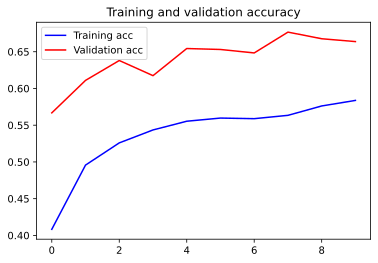

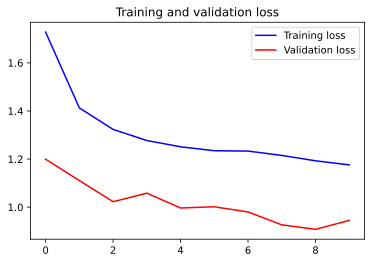

In [ ]:
#Исходная модель: голова заморожена, обучаем хвост
model, base_model = train_model(model,base_model,1.00,LR*1.00,'0',
                                key_fit,train_datagen,test_datagen,EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 26,777,098
Non-trainable params: 2,264,560
____________________________________

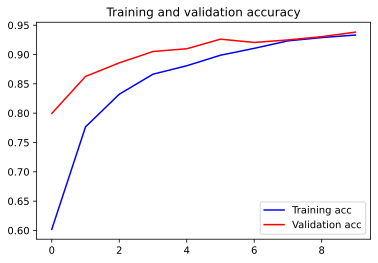

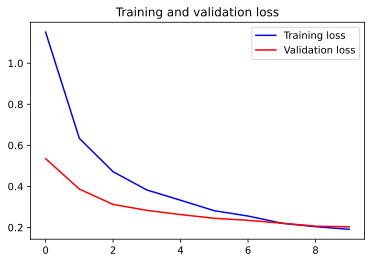

In [ ]:
#Первая модель: голова на 50% разморожена, обучаем хвост и оставшуюся часть головы
model, base_model = train_model(model,base_model,0.50,LR*0.10,'1',
                                key_fit,train_datagen,test_datagen,EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,603,274
Non-trainable params: 438,384
______________________________________

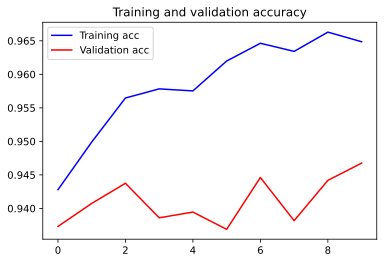

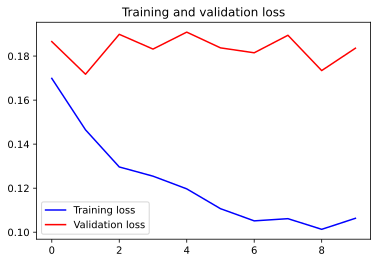

In [ ]:
#Вторая модель: голова на 75% разморожена, обучаем хвост и оставшуюся часть головы
model, base_model = train_model(model,base_model,0.25,LR*0.02,'2',
                                key_fit,train_datagen,test_datagen,EPOCHS)

***
***На следующем этапе количество эпох сокращено до 5, так как при большем количестве начинает падать метрика на валидационной выборке - переобучение.***
***

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,868,410
Non-trainable params: 173,248
______________________________________

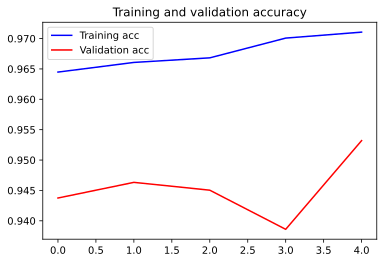

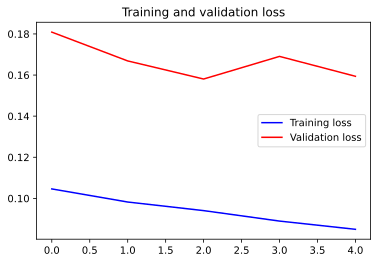

In [ ]:
#Третья модель: голова на 100% разморожена, обучаем хвост и оставшуюся часть головы
model, base_model = train_model(model,base_model,0.00,LR*0.01,'3',
                                key_fit,train_datagen,test_datagen,EPOCHS=5)

***
***Финальный график зависимости функции потерь и метрики приведен в конце notebook.***
***

# 7. Изменение IMAGE_SIZE, BATCH и AUGMENTATION

***
***Для повышения точности предсказания уменьшаем влияние аугментации и увеличиваем размер картинки, при этом снижаем размер батча, чтобы хватило памяти.***
***

In [ ]:
#Изменение глобальных настроек
EPOCHS         = 8
BATCH_SIZE     = 4
LR             = 1e-5
IMG_SIZE       = 512
IMG_CHANNELS   = 3
input_shape    = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

***
***Количество эпох подобрано опытным путем. Оптимальным вариантом является 4-8.***
***

In [ ]:
p = 0.5 #Вероятность изменить изображение
#Создание аугментатора
augment = alb.Compose([
    #Поворот вокруг вертикальной оси
    alb.HorizontalFlip(p=p),
    #Вращение изображения
    alb.ShiftScaleRotate(shift_limit=0.0625,      #Коэффициент изменения сдвига
                         scale_limit=(0.1,0.2),   #Коэффициент изменение масштаба
                         interpolation=1,         #Флаг для вида интерполяции (линейная)
                         border_mode=4,           #Флаг для экстраполяцц (отражение)
                         rotate_limit=20,         #Угол поворота
                         p=0.7),                  #Вероятность
    #Изменение размера на заданный
    alb.Resize(IMG_SIZE, IMG_SIZE)
])
#Генерируем данные заного
#Генератор для обучающей и валидационной выборок
train_gen = ImageDataAugmentor(rescale=1.0/255,                     #Масштабирование
                               augment=augment,                     #Аугментатор
                               seed=RANDOM_SEED,                    #Для воспроизведения
                               validation_split=VAL_SPLIT)          #Размер выборки
#Генератор для тестовой выборки
test_gen = ImageDataGenerator(rescale=1.0/255)
#Создание обучающей выборки
train_datagen = train_gen.\
            flow_from_directory(PATH+'train/',                      #Путь
                                class_mode='categorical',           #Тип данных
                                batch_size=BATCH_SIZE,              #Размер BATCH'а
                                target_size=(IMG_SIZE, IMG_SIZE),   #Размер матрицы
                                shuffle=True,                       #Перемешиваем заранее
                                subset='training')                  #Название
#Создание валидационной выборки
test_datagen = train_gen.\
            flow_from_directory(PATH+'train/',                      #Путь
                                class_mode='categorical',           #Тип данных
                                batch_size=BATCH_SIZE,              #Размер BATCH'а
                                target_size=(IMG_SIZE, IMG_SIZE),   #Размер матрицы
                                shuffle=True,                       #Перемешиваем заранее
                                subset='validation')                #Название
#Создание тестовой выборки
test_sub_generator = test_gen.\
            flow_from_dataframe(dataframe=sample_submission,
                                x_col="Id",
                                y_col=None,
                                directory=PATH+'test_upload/',
                                class_mode=None,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                target_size=(IMG_SIZE, IMG_SIZE),
                                seed=RANDOM_SEED)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
#Создаем голову заново для нового размера картинок
base_model = efn.EfficientNetB5(weights='imagenet',        #Обученная на imagenet
                                include_top=False,         #Включать ли верхнюю часть сети
                                input_shape=input_shape)   #Размер матрицы
#Загружаем веса с прошлой итерации
model.load_weights('best_model_3.hdf5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,868,410
Non-trainable params: 173,248
______________________________________

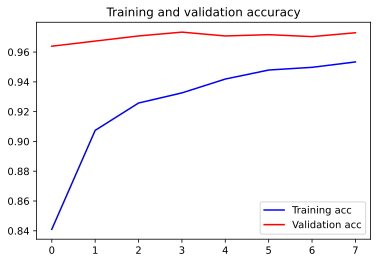

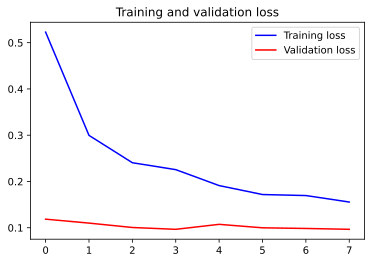

In [ ]:
#Четвертая модель: все разморожено и изменения в BATCH и AUGMENTATION
model, base_model = train_model(model,base_model,0.00,LR,'4',
                                key_fit,train_datagen,test_datagen,EPOCHS)

***
***В результате качество на валидационной выборке было повышено на ~2%. Можно считать данную модель оптимальную из всех полученных ранее.***
***

# 8. Kaggle v.1

In [ ]:
def to_Kaggle(model):
    #Код взят с SkillFactory
    test_sub_generator.reset()
    predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions = np.argmax(predictions, axis=-1)
    label_map = (train_datagen.class_indices)
    label_map = dict((v,k) for k,v in label_map.items())
    predictions = [label_map[k] for k in predictions]
    filenames_with_dir=test_sub_generator.filenames
    submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/','')
    submission.to_csv('submission.csv', index=False)
    print('Save submit')
    pass

***
***Результат на Kaggle приведен в конце notebook.***
***

In [ ]:
#submit на Kaggle
to_Kaggle(model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 234s 139ms/step
Save submit


# 9. TTA

***
***Так как исходная модель была обучена на изображениях с аугментацией, то применим к тестовой выборке такую же аугментацию n раз. В результате усредним значения вероятностей.***
***

In [ ]:
p = 0.5 #Вероятность изменить изображение
#Создание аугментатора
augment = alb.Compose([
    #Замена каналов в RGB палитре
    alb.ChannelShuffle(p=p),
    #Размытие изображения
    alb.GaussianBlur(p=p),
    #Добавление шума
    alb.GaussNoise(p=p),
    #Поворот вокруг вертикальной оси
    alb.HorizontalFlip(p=p),
    #Изменение оттенка и насыщенности
    alb.HueSaturationValue(p=p),
    #Изменение яркости
    alb.RandomBrightness(p=p,limit=(0.2,0.4)),
    #Изменение контраста
    alb.RandomContrast(p=p,limit=(0.1,0.3)),
    #Сдвиг в RGB палитре
    alb.RGBShift(p=p),
    #Вращение изображения
    alb.ShiftScaleRotate(shift_limit=0.0625,      #Коэффициент изменения сдвига
                         scale_limit=(0.1,0.2),   #Коэффициент изменение масштаба
                         interpolation=1,         #Флаг для вида интерполяции (линейная)
                         border_mode=4,           #Флаг для экстраполяцц (отражение)
                         rotate_limit=20,         #Угол поворота
                         p=0.7),                  #Вероятность
    #Изменение размера на заданный
    alb.Resize(IMG_SIZE, IMG_SIZE)
])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
#Генерируем данные заного
#Генератор для обучающей и валидационной выборок
test_gen =  ImageDataAugmentor(rescale=1.0/255,                     #Масштабирование
                               augment=augment,                     #Аугментатор
                               seed=RANDOM_SEED,                    #Для воспроизведения
                               validation_split=VAL_SPLIT)          #Размер выборки
#Создание тестовой выборки
test_sub_generator = test_gen.\
            flow_from_dataframe(dataframe=sample_submission,
                                x_col="Id",
                                y_col=None,
                                directory=PATH+'test_upload/',
                                class_mode=None,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                target_size=(IMG_SIZE, IMG_SIZE),
                                seed=RANDOM_SEED)

Found 6675 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


***
***Количество изменений было подобрано опытным путем. Значения 10-12 являются оптимальными. Больше не дает существенного прироста, а меньше уменьшают значение метрики.***
***

In [ ]:
#Количество изменений
n_tta = 12
#Массив для сохранений
predictions = []
#Перебор
for i in range(n_tta):
    print('{} / {}'.format(1+i, n_tta))
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

1 / 0
1669/1669 [==============================] - 306s 184ms/step
2 / 1
1669/1669 [==============================] - 309s 185ms/step
3 / 2
1669/1669 [==============================] - 306s 183ms/step
4 / 3
1669/1669 [==============================] - 308s 185ms/step
5 / 4
1669/1669 [==============================] - 308s 184ms/step
6 / 5
1669/1669 [==============================] - 310s 186ms/step
7 / 6
1669/1669 [==============================] - 309s 185ms/step
8 / 7
 677/1669 [===========>..................] - ETA: 3:03

***
***TTA позволил улучшить результат на ~0.2%. Как видно по выводу notebook - в этот момент у меня закончились часы на Google Colab. Но расчет уже был получен ранее и загружен на Kaggle.***
***

# 10. Kaggle v.2

***
***Результат на Kaggle приведен в конце notebook.***
***

In [ ]:
#Взятие среднего
pred = np.mean(predictions, axis=0)

In [ ]:
#Функция для вывода на Kaggle TTA
def to_Kaggle_TTA(predictions):
    predictions = np.argmax(predictions, axis=-1)
    label_map = (train_datagen.class_indices)
    label_map = dict((v,k) for k,v in label_map.items())
    predictions = [label_map[k] for k in predictions]
    filenames_with_dir=test_sub_generator.filenames
    submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/','')
    submission.to_csv('submission_TTA.csv', index=False)
    print('Save submit')
    pass

In [ ]:
#submit на Kaggle
to_Kaggle_TTA(pred)

***
# Вывод
***

In [ ]:
#График LinePlot
def lineplot(data,x,y,order=None,
             hue=None,hue_order=None,style=None,size_order=None,
             size=(15,6),xlim=None,ylim=None): 
    #Plot
    fig, ax = plt.subplots(1, 1, figsize=size)
    #Title
    fig.suptitle('Line-Plot for {}({}) by groups of {}'.\
                 format(x,y,hue))
    #Limits
    if xlim:
        ax.set(xlim=xlim)
    if ylim:
        ax.set(ylim=ylim)
    #Plot-Seaborn
    sns.lineplot(data=data,x=x,y=y,
                 hue=hue,hue_order=hue_order,style=style,size_order=size_order,
                 ax=ax)
    #Show
    plt.show()
    pass

In [ ]:
#Таблица результатов
df = pd.DataFrame({'epochs': np.hstack([np.arange(1,44),np.arange(1,44)]),
                   'accuracy': [0.3468,0.4884,0.5251,0.5412,0.5601,0.5583,0.561,0.5656,0.568,0.5829,0.5065,0.7594,0.8252,0.8576,0.8825,0.896,0.9142,0.9272,0.9276,0.9356,0.9366,0.9489,0.9557,0.9594,0.9581,0.9658,0.9656,0.9634,0.9681,0.9642,0.9644,0.9655,0.9689,0.9723,0.9711,0.7995,0.902,0.9261,0.932,0.6404,0.6517,0.9481,0.9486,0.5668,0.611,0.638,0.6174,0.6544,0.6531,0.6483,0.6767,0.6677,0.6638,0.7995,0.8626,0.8858,0.9051,0.9098,0.9261,0.9206,0.9249,0.9304,0.9382,0.9373,0.9407,0.9438,0.9386,0.9395,0.9369,0.9446,0.9382,0.9442,0.9468,0.9438,0.9463,0.945,0.9386,0.9532,0.9639,0.9674,0.9708,0.9734,0.9708,0.9717,0.9704,0.9729],
                   'los_trn': [2.0109,1.427,1.3352,1.2759,1.2453,1.2279,1.225,1.2104,1.2106,1.1693,1.4963,0.6715,0.4893,0.4003,0.3316,0.2871,0.2429,0.2129,0.2063,0.1858,0.1846,0.1468,0.1343,0.123,0.12,0.1057,0.1044,0.1031,0.0977,0.1061,0.1071,0.0985,0.0957,0.0857,0.0835,0.664,0.3208,0.2375,0.236,0.1977,0.1575,0.1685,0.1664,1.1992,1.1404,1.0226,1.0581,0.9965,1.0015,0.9799,0.9264,0.9078,0.9448,0.535,0.3869,0.312,0.2832,0.2627,0.2447,0.2348,0.2206,0.2061,0.2029,0.1866,0.1718,0.1899,0.1832,0.1909,0.1837,0.1815,0.1895,0.1734,0.1836,0.1809,0.1669,0.1581,0.1691,0.1594,0.1185,0.1101,0.1006,0.0966,0.1074,0.0999,0.0985,0.0966],
                   'iter': [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4],
                   'type': ['train']*43+['valid']*43})

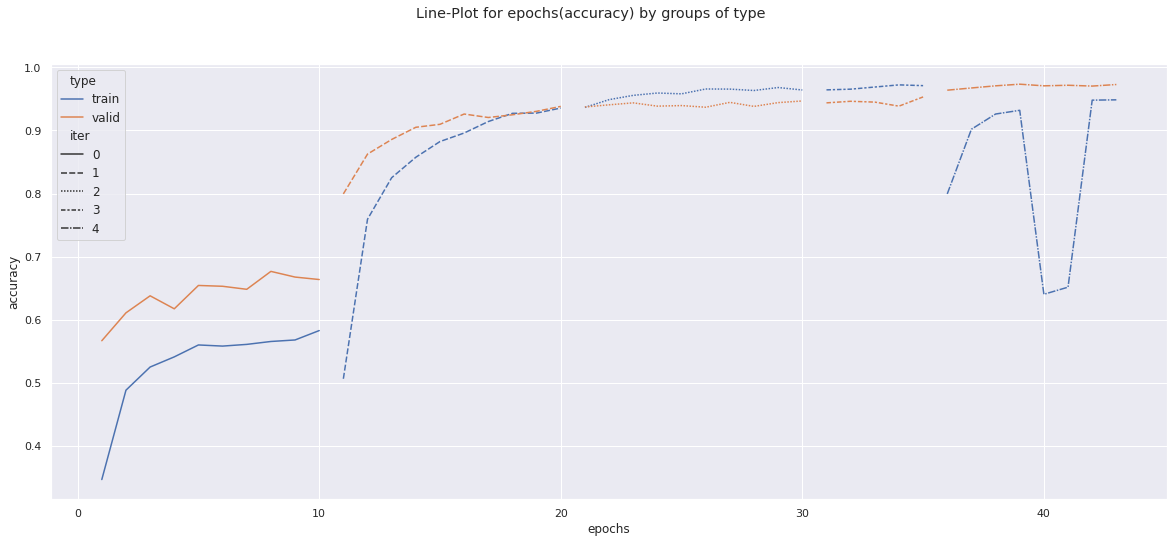

In [ ]:
#Вывод графика
lineplot(df,'epochs','accuracy',hue='type',size=(20,8),style='iter')

***
***По графику видно, что достигнута точность на валидационной выборке ~97.2%. При этом точность на обучающей выборке практически всегда ниже, чем на валидационной, вследствии чего можно утверждать, что переобучения модели нет. Также в процессе выполнения проекта количество эпох подбиралось таким образом, чтобы качество на валидационной выборке не начинало стремительно падать (переобучение).***
***

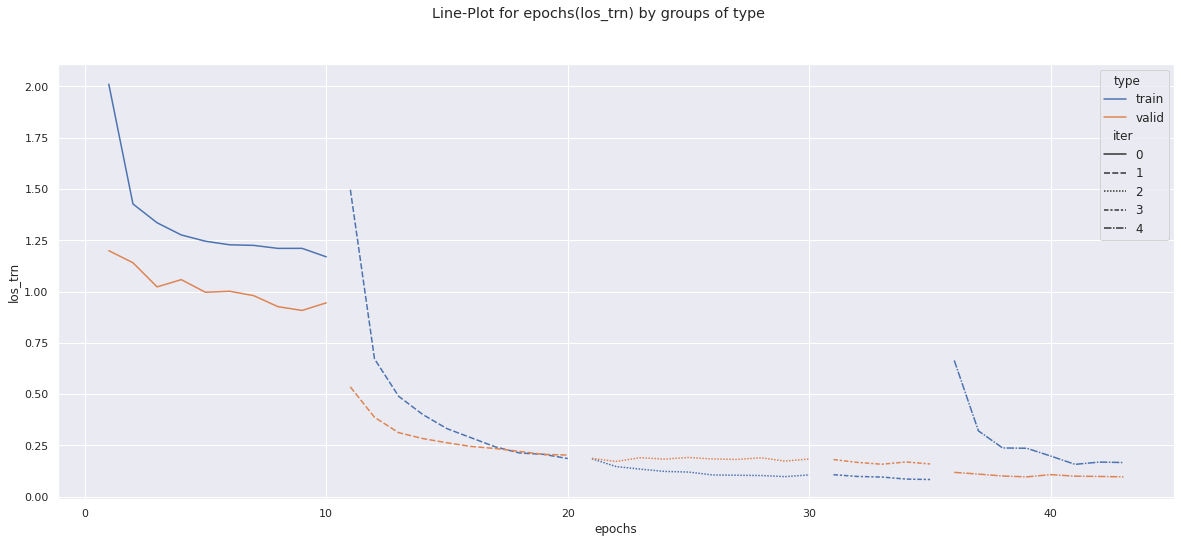

In [ ]:
#Вывод графика
lineplot(df,'epochs','los_trn',hue='type',size=(20,8),style='iter')

***
***По аналогичному графику функции потерь видно, что обучение модели выполнено правильно. Вопросы может вызвать разве что 3 и 4 итерации, когда метрика на валидации чуть ниже, чем на обучении.***
***

***
***В данной работе применение fine-tuning и transfer learning позволило сократить общее время вычисления, не тратить силы и время на конструирование архитектуры сети и использовать уже готовые модели (efficientnet B5, efficientnet B6 и т.д.) с дальнейшим их переобучением под данную задачу. Аугментация данных позволила разнообразить исходный датасет и повысить качество модели. Для аугментации изображений использовалась библиотека albumentations. Также качество модели позволил улучшить метод TTA - аугментация данных к тестовой выборке n раз и осреднение результатов.***
***

***
***Максимальный результат, достигнутый на Kaggle, со второй попытки, 0.97453 - применение transfer learning+fine-tuning, аугментации данных и TTA. Для решения без TTA - 0.97438. Для решения без увеличения картинки, снижения батча и уменьшения аугментации - 0.95655. Попытка заменить в оптимальном варианте функцию relu на elu привела к значению 0.97348. К сожалению не хватило чуть-чуть времени на видеокарте для того, чтобы посчитать размер батча 16 + изменение количества эпох (буквально часа 2), Google Colab отрубил расчет под конец и все данные были потеряны. Но уже на этапе без применения TTA метрика относительно значения 0.97438 была улучшена до 0.97453 (как на лучшем варианте с TTA), что может наводить на мысль о том, что дальнейшее применение TTA позволит еще чуть-чуть повысить метрику на тестовой выборке.***
***

***
***Одним из вариантов улучшения текущего решения может являться применения модели B6 с более тонкими настройками. Также следующим шагом может быть попытка совмещения B6 и B5 в виде ансамбля. Качество может быть значительно повышено при более тонкой настройке темпа обучения (но время для обучения кончилось).***
***

# Ссылка на Git-Hub: https://github.com/MirtosSergey/SF_project/tree/master/module_7.
# Ник на Kaggle: MirtosSergey.
#### На 06.05.2021: 18/180 на Kaggle - 0.97453.

